<hr style="height:2px;">

# Demo: Denoising of 2D cell images

This notebook demonstrates training a CARE model for a 2D denoising task, assuming that training data was already generated via [1_datagen.ipynb](1_datagen.ipynb) and has been saved to disk to the file ``data/my_training_data.npz``.

Note that training a neural network for actual use should be done with more training time as used here.

More Documentation is available at http://csbdeep.bioimagecomputing.com/doc/.

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from tifffile import imread
from csbdeep.utils import axes_dict, plot_some, plot_history
from csbdeep.utils.tf import limit_gpu_memory
from csbdeep.io import load_training_data
from csbdeep.models import Config, CARE

**Important**: As the TensorFlow backend uses all available GPU memory by default, please make sure that all other notebooks that use the GPU (e.g. training/prediction notebooks) are shut down before running this notebook. This can be done via the "Running" tab in the main "Home" notebook server page.

In [2]:
import tensorflow as tf #Device Name
print('Device Name:' +tf.test.gpu_device_name())# Version-check
print('Version:' +tf.__version__)#CUDA Support
print('CUDA Support: '+str(tf.test.is_built_with_cuda()))

Device Name:/device:GPU:0
Version:2.6.0-dev20210525
CUDA Support: True


<hr style="height:2px;">

# Training and validation data

Here we load the data patches generated via [1_datagen.ipynb](1_datagen.ipynb), and split them into 95% actual training data and 5% *validation data*. The latter is used during model training as independent indicator of the restoration accuracy. Model performance on the training data is often better than on the validation data, in which case the model is *overfitting*. Monitoring the validation performance gives us a chance to detect that. 

In [31]:
(X,Y), (X_val,Y_val), axes = load_training_data('N:/BROADMODELS/datamix/train/datamix3NOV_binned_nondw_dw.npz', validation_split=0.05, verbose=True)

c = axes_dict(axes)['C']
n_channel_in, n_channel_out = X.shape[c], Y.shape[c]

number of training images:	 241254
number of validation images:	 12698
image size (2D):		 (128, 128)
axes:				 SYXC
channels in / out:		 1 / 1


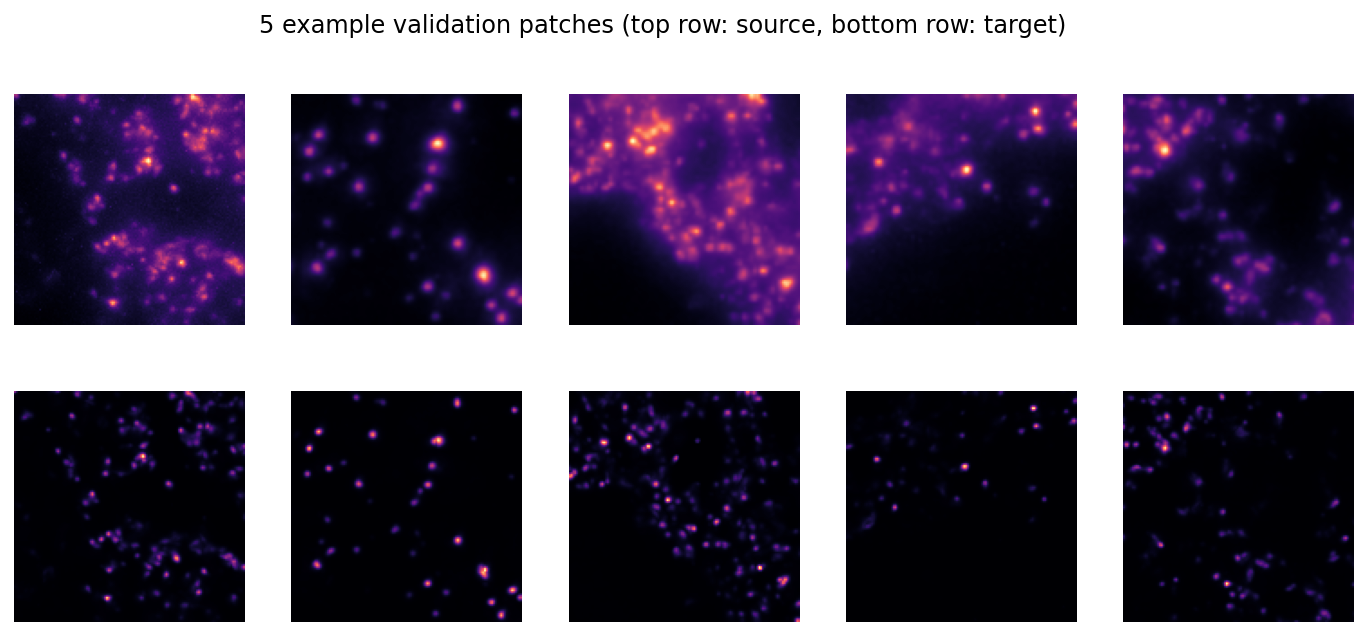

In [32]:
plt.figure(figsize=(12,5))
plot_some(X_val[:5],Y_val[:5])
plt.suptitle('5 example validation patches (top row: source, bottom row: target)');

<hr style="height:2px;">

# CARE model


Before we construct the actual CARE model, we have to define its configuration via a `Config` object, which includes 
* parameters of the underlying neural network (a rather small 2D U-Net with 2x max pooling),
* the learning rate,
* the number of parameter updates per epoch,
* the loss function, and
* whether the model is probabilistic or not.

![](imgs/carenet.png)

The defaults should be sensible in many cases, so a change should only be necessary if the training process fails.  

---

<span style="color:red;font-weight:bold;">Important</span>: Note that for this notebook we use a very small number of update steps per epoch for immediate feedback, whereas this number should be increased considerably (e.g. `train_steps_per_epoch=400`) to obtain a well-trained model.

take care of the default batch size shoult be 8

In [33]:
config = Config(axes, n_channel_in, n_channel_out, unet_kern_size=3, train_batch_size=8, train_steps_per_epoch=400, train_epochs=100)
print(config)
vars(config)

Config(axes='YXC', n_channel_in=1, n_channel_out=1, n_dim=2, probabilistic=False, train_batch_size=8, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_epochs=100, train_learning_rate=0.0004, train_loss='mae', train_reduce_lr={'factor': 0.5, 'patience': 10, 'min_delta': 0}, train_steps_per_epoch=400, train_tensorboard=True, unet_input_shape=(None, None, 1), unet_kern_size=3, unet_last_activation='linear', unet_n_depth=2, unet_n_first=32, unet_residual=True)


{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'probabilistic': False,
 'unet_residual': True,
 'unet_n_depth': 2,
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 1),
 'train_loss': 'mae',
 'train_epochs': 100,
 'train_steps_per_epoch': 400,
 'train_learning_rate': 0.0004,
 'train_batch_size': 8,
 'train_tensorboard': True,
 'train_reduce_lr': {'factor': 0.5, 'patience': 10, 'min_delta': 0}}

We now create a CARE model with the chosen configuration:

In [34]:
model = CARE(config, 'binned_nondw_to_dw__100epoch3NOV', basedir='N:/BROADMODELS/datamix/models')

We can inspect the created neural network:

In [35]:
model.keras_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, None,  0                                            
__________________________________________________________________________________________________
down_level_0_no_0 (Conv2D)      (None, None, None, 3 320         input[0][0]                      
__________________________________________________________________________________________________
down_level_0_no_1 (Conv2D)      (None, None, None, 3 9248        down_level_0_no_0[0][0]          
__________________________________________________________________________________________________
max_0 (MaxPooling2D)            (None, None, None, 3 0           down_level_0_no_1[0][0]          
____________________________________________________________________________________________

<hr style="height:2px;">

# Training


Training the model will likely take some time. We recommend to monitor the progress with TensorBoard (example below), which allows you to inspect the losses during training. Furthermore, you can look at the predictions for some of the validation images, which can be helpful to recognize problems early on.


You can monitor the progress during training with [TensorBoard](https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard) by starting it from the current working directory:

    $ tensorboard --logdir=.

Then connect to [http://localhost:6006/](http://localhost:6006/) with your browser.


![](http://csbdeep.bioimagecomputing.com/img/tensorboard_denoising2D.png)


In [36]:
history = model.train(X,Y, validation_data=(X_val,Y_val))

Epoch 1/100
Cause: could not parse the source code of <function _mean_or_not.<locals>.<lambda> at 0x000001B99FAD7D30>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names.
Match 0:
(lambda x: K.mean(x, axis=(- 1)))

Match 1:
(lambda x: x)

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function _mean_or_not.<locals>.<lambda> at 0x000001B99FAD7D30>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names.
Match 0:
(lambda x: K.mean(x, axis=(- 1)))

Match 1:
(lambda x: x)

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function _mean_or_not.<locals>.<lambda> at 0x000001B99FAD7DC0>: found

Plot final training history (available in TensorBoard during training):

['loss', 'lr', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse']


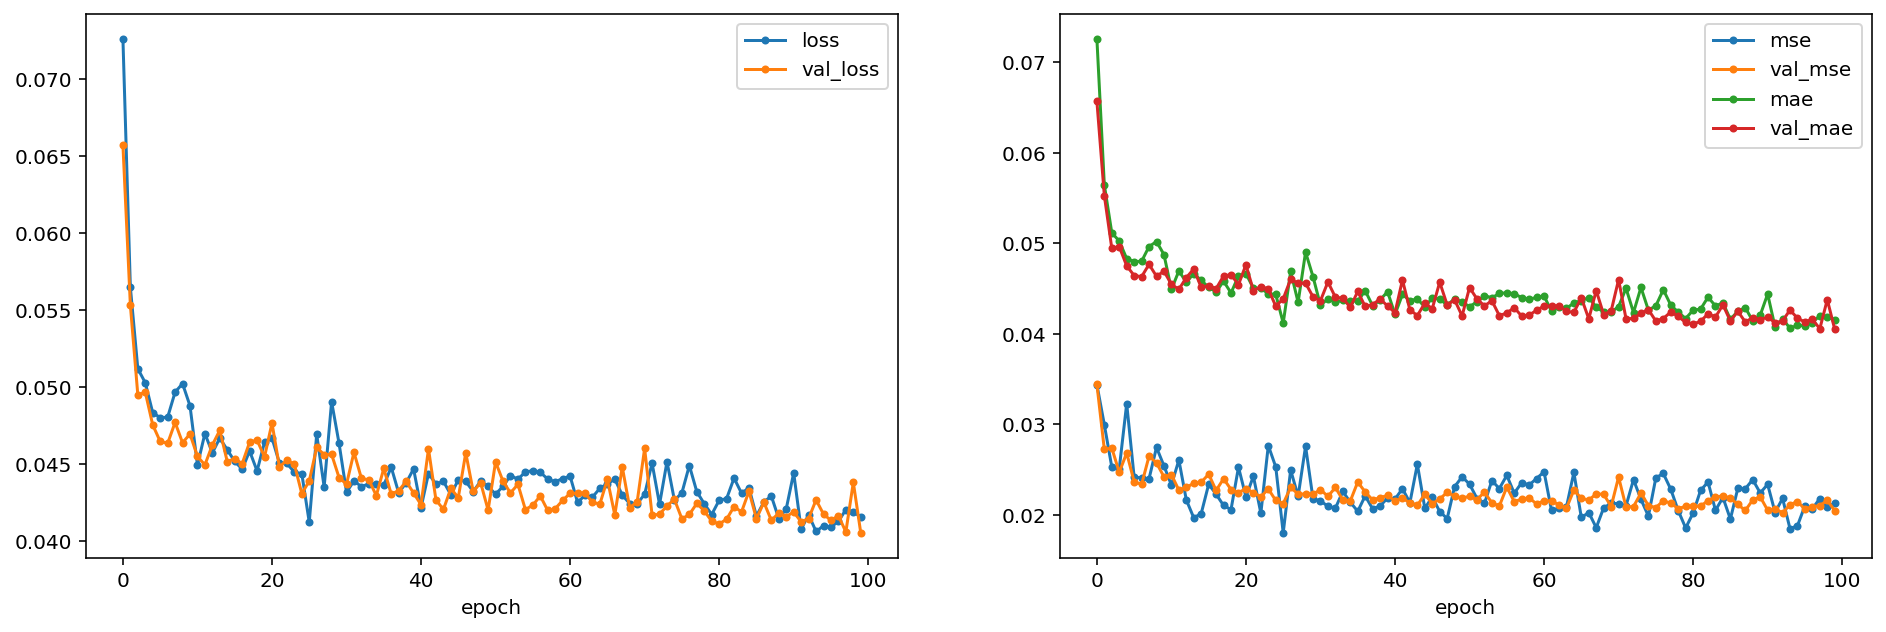

In [37]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss'],['mse','val_mse','mae','val_mae']);

<hr style="height:2px;">

# Evaluation

Example results for validation images.

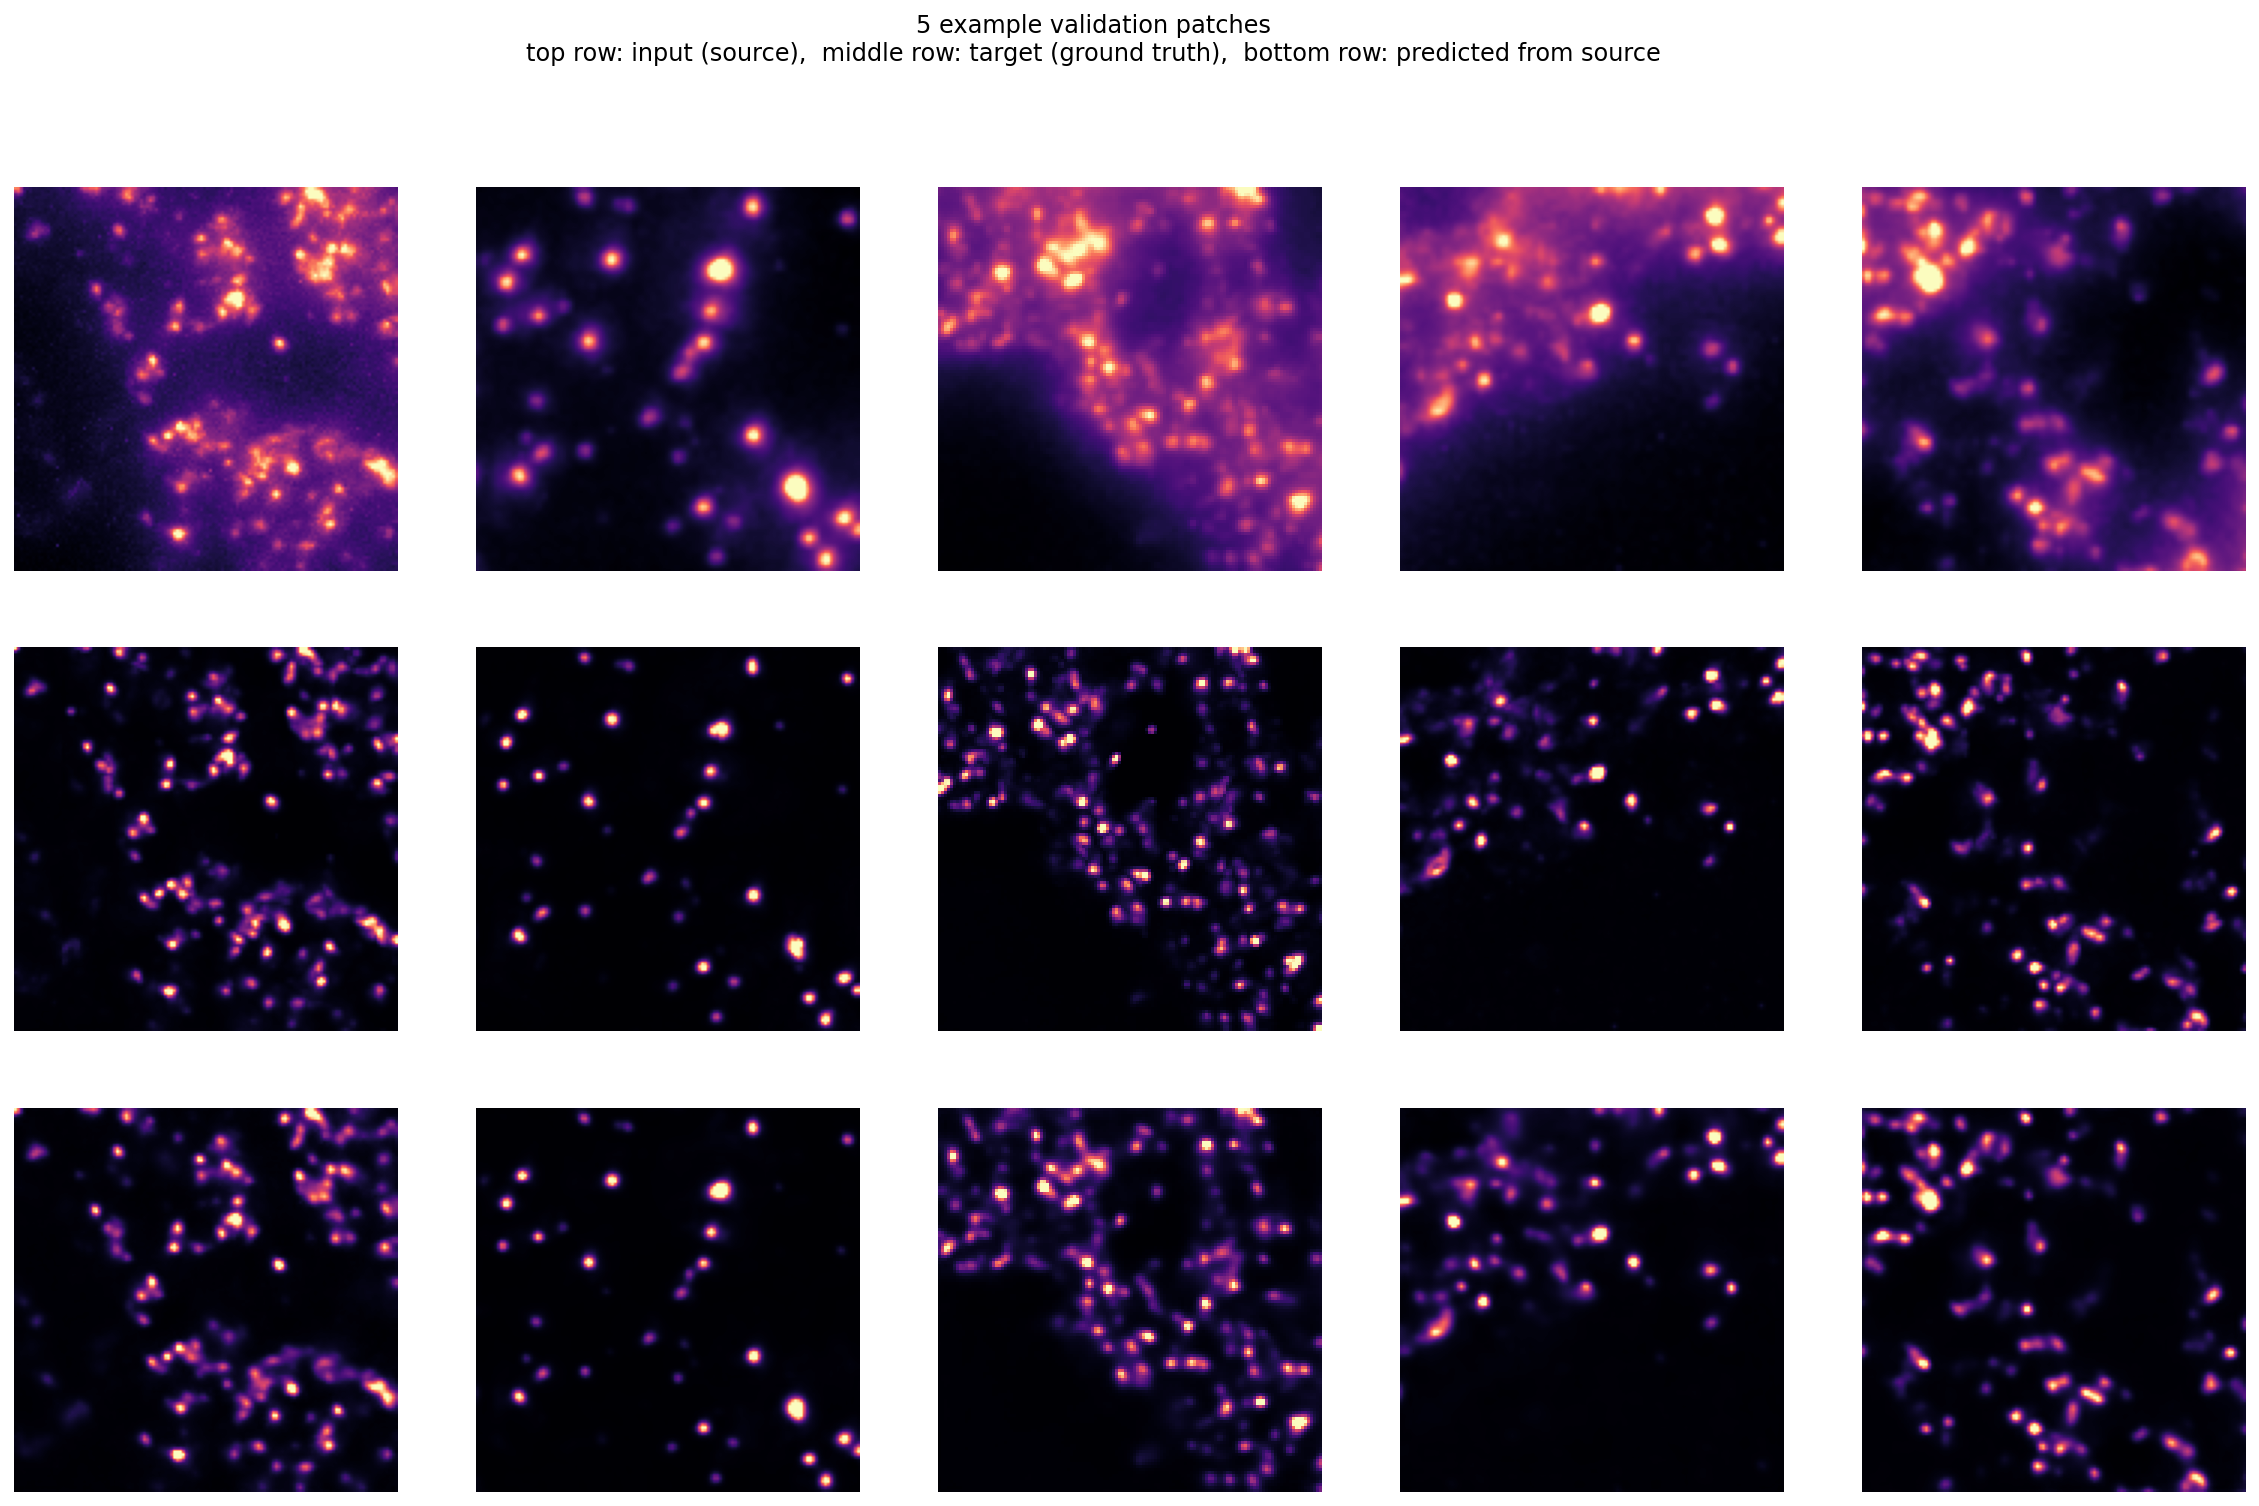

In [38]:
plt.figure(figsize=(20,12))
_P = model.keras_model.predict(X_val[:5])
if config.probabilistic:
    _P = _P[...,:(_P.shape[-1]//2)]
plot_some(X_val[:5],Y_val[:5],_P,pmax=99.5)
plt.suptitle('5 example validation patches\n'      
             'top row: input (source),  '          
             'middle row: target (ground truth),  '
             'bottom row: predicted from source');

<hr style="height:2px;">

# Export model to be used with CSBDeep **Fiji** plugins and **KNIME** workflows

See https://github.com/CSBDeep/CSBDeep_website/wiki/Your-Model-in-Fiji for details.

In [ ]:
model.export_TF()


In [11]:
 conda list cudnn

# packages in environment at C:\Users\marco.grillo\.conda\envs\tensorflow:
#
# Name                    Version                   Build  Channel

Note: you may need to restart the kernel to use updated packages.
